In [2]:
pip install transformers torchaudio librosa


   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------- ----------- 7.3/10.4 MB 37.8 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 34.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 39.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 50.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 27.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   ----------- ---------------------------- 8.1/28.1 MB 38.6 MB/s eta 0:00:01
   ------------------- -------------------- 13.9/28.1 MB 36.4 MB/s eta 0:00:01
   ----------------------------- ---------- 20.7/28.1 MB 33.5 MB/s eta 0:00:01
   -------------------------

In [9]:
import numpy as np
import torch
from tqdm import tqdm
from transformers import ASTFeatureExtractor, ASTForAudioClassification

# 1. 모델 및 feature extractor 불러오기
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model.eval()

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=T

In [10]:
# 2. waveform dictionary 불러오기
waveform_dict = np.load("audio_waveform_test.npy", allow_pickle=True).item()

# 3. 결과 저장용 딕셔너리
pred_dict = {}
skipped_keys = []

# 4. 예측 수행
for key, waveform in tqdm(waveform_dict.items()):
    try:
        # 1D numpy array로 squeeze
        waveform = np.array(waveform).squeeze()

        # 너무 짧은 waveform은 스킵
        if len(waveform) < 400:
            skipped_keys.append((key, "Too short"))
            continue

        # Feature extraction 및 모델 예측
        inputs = feature_extractor(
            waveform,
            sampling_rate=16000,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.sigmoid(outputs.logits).squeeze().numpy()  # [527]
            pred_dict[key] = probs

    except Exception as e:
        skipped_keys.append((key, str(e)))
        continue

# 5. 결과 저장
np.save("ast_pred_test.npy", pred_dict)
np.save("ast_pred_test_skipped.npy", skipped_keys)  # 오류나 건너뛴 항목 저장

100%|██████████| 1967/1967 [43:21<00:00,  1.32s/it]


여기 아래서부터는 npy 잘 저장된 건지 확인

In [12]:
import numpy as np

data = np.load("ast_pred_test.npy", allow_pickle=True).item()

# 전체 항목 수 확인
print(f"총 예측 항목 수: {len(data)}")

# 예시 하나 출력
for key, value in list(data.items())[:3]:  # 처음 3개만 보기
    print(f"Key: {key}, Shape: {value.shape}, 예측값 일부: {value[:5]}")
    break


총 예측 항목 수: 1967
Key: ('adult+female+singing', '2cEKxGB6-YM_35'), Shape: (527,), 예측값 일부: [0.04407879 0.00038012 0.00077621 0.0021644  0.00010693]


In [13]:
print(list(data.keys())[:10])  # 앞에서 10개 키만 보기


[('adult+female+singing', '2cEKxGB6-YM_35'), ('adult+female+singing', 'getty-factory-workers-singing-and-dancing-during-lunch-break-united-kingdom-video-idmr_00076507_35'), ('adult+female+singing', 'peeks-www_k_to_keek_13aweab_10'), ('adult+female+singing', 'peeks-www_k_to_keek_1Pwoeab_13'), ('adult+female+singing', 'peeks-www_k_to_keek_27Jueab_9'), ('adult+female+singing', 'peeks-www_k_to_keek_5frweab_28'), ('adult+female+singing', 'peeks-www_k_to_keek_5kAueab_9'), ('adult+female+singing', 'peeks-www_k_to_keek_62fpeab_15'), ('adult+female+singing', 'peeks-www_k_to_keek_6Cmqeab_1'), ('adult+female+singing', 'peeks-www_k_to_keek_7AExeab_29')]


Top-5 예측 인덱스: [137  35  33  34   0]
Top-5 확률: [0.751714   0.4047942  0.10911546 0.05419272 0.04407879]


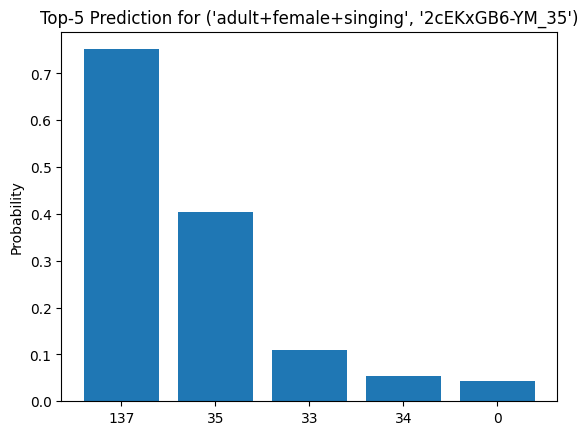

In [15]:
import matplotlib.pyplot as plt

sample_key = list(data.keys())[0]
sample_probs = data[sample_key]

top5_indices = sample_probs.argsort()[-5:][::-1]
top5_probs = sample_probs[top5_indices]

print("Top-5 예측 인덱스:", top5_indices)
print("Top-5 확률:", top5_probs)

plt.bar(range(5), top5_probs)
plt.xticks(range(5), top5_indices)
plt.ylabel("Probability")
plt.title(f"Top-5 Prediction for {sample_key}")
plt.show()


여기서부터는 인덱스 - 의미 매핑

In [16]:
from transformers import ASTForAudioClassification
import numpy as np

# 모델 불러오기
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
id2label = model.config.id2label  # {int: str}


In [17]:
# 예측 결과 불러오기
pred_dict = np.load("ast_pred_test.npy", allow_pickle=True).item()

# Top-k 예측 결과를 이름으로 매핑해서 저장
topk = 5
mapped_dict = {}

for key, probs in pred_dict.items():
    topk_indices = probs.argsort()[-topk:][::-1]  # 큰 값부터 정렬
    topk_labels = [id2label[idx] for idx in topk_indices]
    topk_scores = [float(probs[idx]) for idx in topk_indices]

    mapped_dict[key] = {
        "topk_labels": topk_labels,
        "topk_scores": topk_scores
    }


In [20]:
import json

json_mapped_dict = {
    f"{k[0]}|{k[1]}": v for k, v in mapped_dict.items()
}

with open("ast_pred_test_top5.json", "w") as f:
    json.dump(json_mapped_dict, f, indent=2)



In [19]:
np.save("ast_pred_test_top5.npy", mapped_dict)
